# Notebook 2: Exploratory Data Analysis (EDA) & Feature Selection
## Heart Disease Dataset

**Purpose:**  
Explore the heart disease dataset to understand variable distributions, relationships, and quality issues. Prepare candidate features for modeling.

**Key Goals:**  

- Check dataset structure and missing values

- Inspect target variable distribution

- Explore numeric & categorical features

- Identify correlations

- Save cleaned dataset & figures


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency

# Optional profiling
try:
    from ydata_profiling import ProfileReport
    PROFILING_AVAILABLE = True
except ImportError:
    PROFILING_AVAILABLE = False

# Output directories
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/datasets/collection", exist_ok=True)

# Plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)



## Step 2. Load Dataset
**Purpose:** Ensure correct dataset loading.  
**Approach:** Load CSV and inspect first rows, datatypes, and missing values.  
**Expected Outcome:** Dataset verified for downstream analysis.

Helper Functions

Define reusable functions for:
- Data cleaning
- Plotting numeric and categorical distributions
- Computing categorical associations (Cramér's V)
- Binning numeric features for target visualization


In [ ]:
df = pd.read_csv("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")

print("Shape:", df.shape)
display(df.head())
display(df.info())


Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


None

## Step 2. Missing Values Summary

**Purpose:** Quantify missing data for each column using a table and bar chart.

,Missing Count,Missing %
ca,611,66.41
thal,486,52.83
slope,309,33.59
fbs,90,9.78
oldpeak,62,6.74
trestbps,59,6.41
exang,55,5.98
thalch,55,5.98
chol,30,3.26
restecg,2,0.22


/tmp/ipykernel_55931/305660139.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


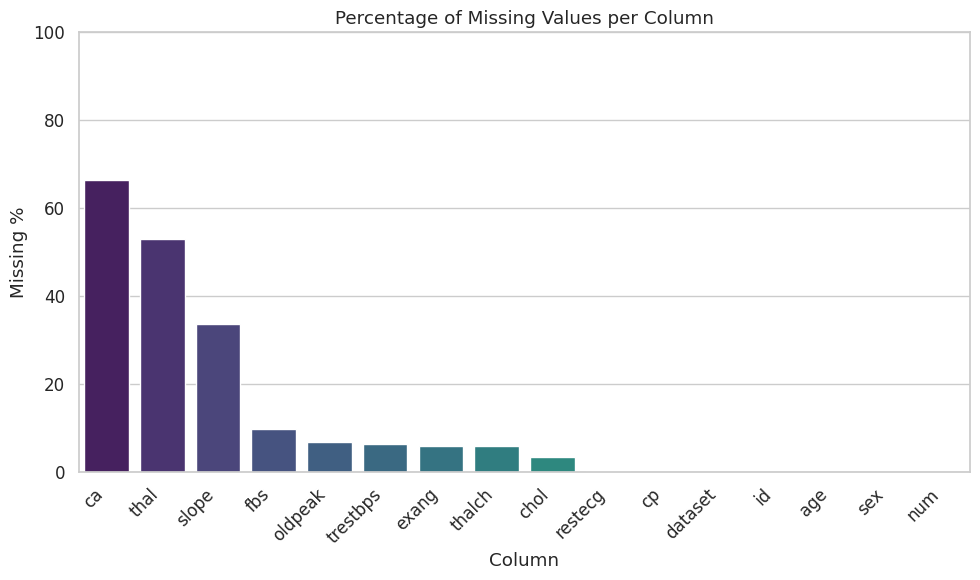

In [3]:
missing_summary = df.isna().sum().to_frame(name='Missing Count')
missing_summary['Missing %'] = (missing_summary['Missing Count'] / len(df) * 100).round(2)
missing_summary = missing_summary.sort_values('Missing %', ascending=False)
display(missing_summary)

plt.figure(figsize=(10,6))
sns.barplot(
    x=missing_summary.index,
    y='Missing %',
    data=missing_summary.reset_index(),
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Missing %')
plt.xlabel('Column')
plt.title('Percentage of Missing Values per Column')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


## Step 3. Target Variable Distribution
**Purpose:** Understand class balance for `num` (0 = absence, 1-4 = stages of heart disease).  
**Approach:** Barplot with percentage annotations.  
**Expected Outcome:** Visual summary of target distribution.

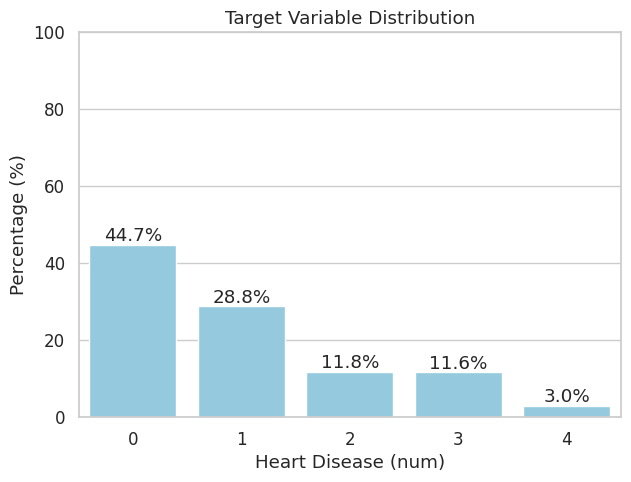

In [4]:
target_percent = df["num"].value_counts(normalize=True) * 100
target_labels = target_percent.index

plt.figure(figsize=(7,5))
ax = sns.barplot(x=target_labels, y=target_percent.values, color="skyblue")
for i, pct in enumerate(target_percent.values):
    ax.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.title("Target Variable Distribution")
plt.xlabel("Heart Disease (num)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.savefig("outputs/figures/target_distribution.png", bbox_inches="tight")
plt.show()

## Step 4. Numerical Features Overview
**Purpose:** Examine numeric distributions, detect anomalies/outliers.  
**Approach:** Summary stats, histograms, zero checks, binned feature plots.  
**Expected Outcome:** Insight into numeric feature ranges and quality.

,count,mean,std,min,25%,50%,75%,max,unique
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0,920
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0,50
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0,61
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0,217
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0,119
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2,53
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0,4
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0,5


trestbps: 1 zeros out of 920
chol: 172 zeros out of 920
ca: 181 zeros out of 920


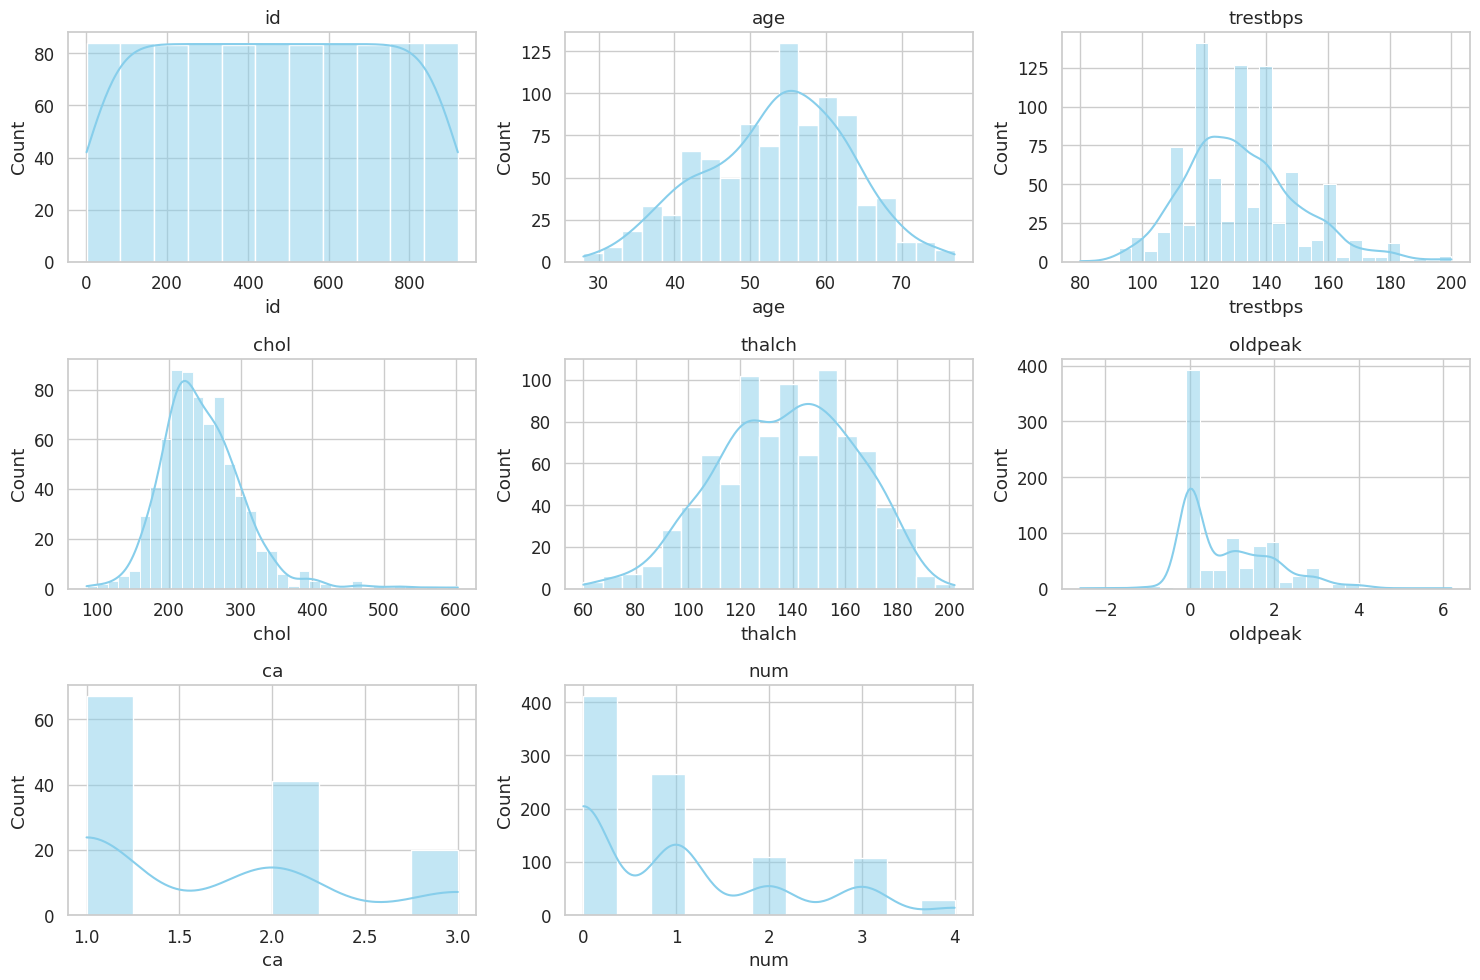

In [5]:
numerical_vars = df.select_dtypes(include='number').columns.tolist()
summary = df[numerical_vars].describe().T
summary["unique"] = df[numerical_vars].nunique()
display(summary)

# Zero checks for suspicious features
# Zero checks for suspicious features
zero_cols = ['trestbps', 'chol', 'ca']
for col in zero_cols:
    if col in df.columns:
        print(f"{col}: {(df[col]==0).sum()} zeros out of {len(df)}")


# Replace impossible zeros with NA
df[zero_cols] = df[zero_cols].replace(0, pd.NA)

# Histograms
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color="skyblue")
    plt.title(col)
plt.tight_layout()
plt.savefig("outputs/figures/numerical_histograms.png", bbox_inches="tight")
plt.show()

## Step 5. Binned Numerical Features vs Target
**Purpose:** Understand target distribution across meaningful numeric ranges.  
**Approach:** Bin features like age, cholesterol, BP, heart rate, ST depression; plot target percentages.  
**Expected Outcome:** Insights into risk trends across numeric bins.

/tmp/ipykernel_55931/502267820.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


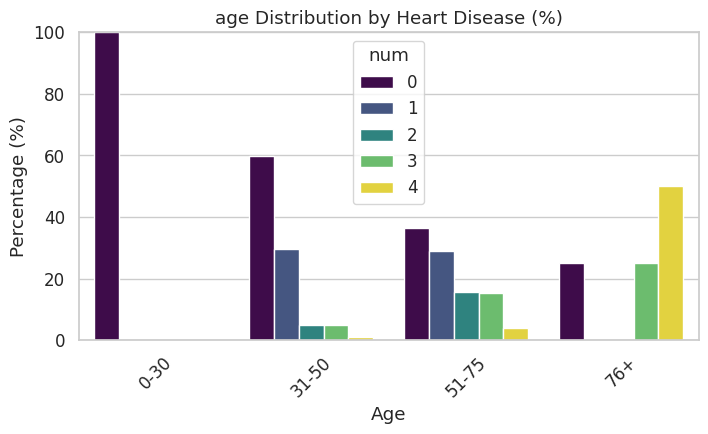

/tmp/ipykernel_55931/502267820.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


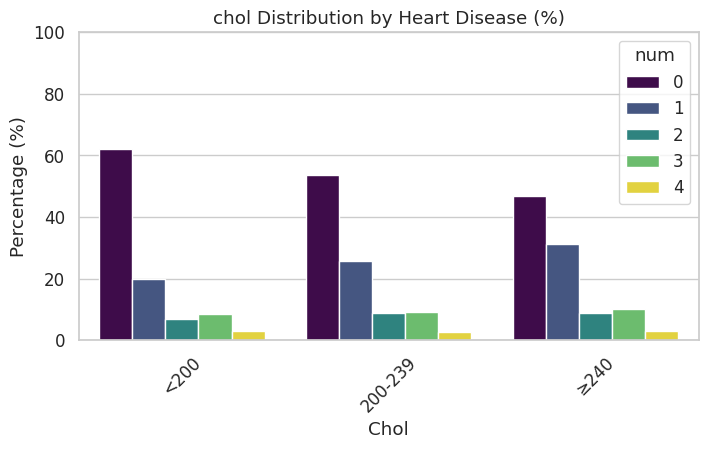

/tmp/ipykernel_55931/502267820.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


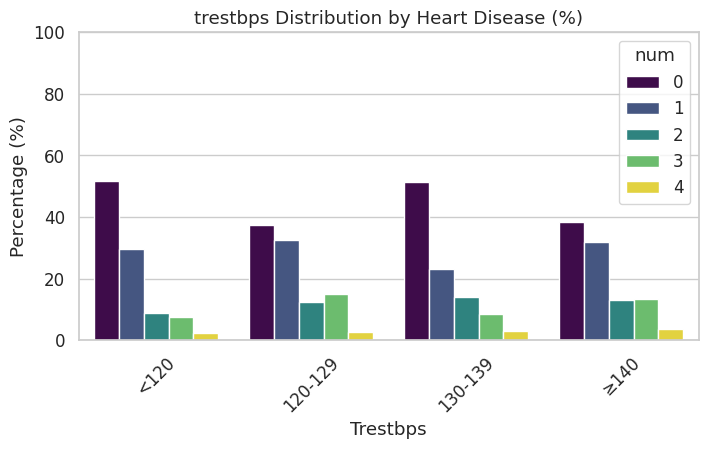

/tmp/ipykernel_55931/502267820.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


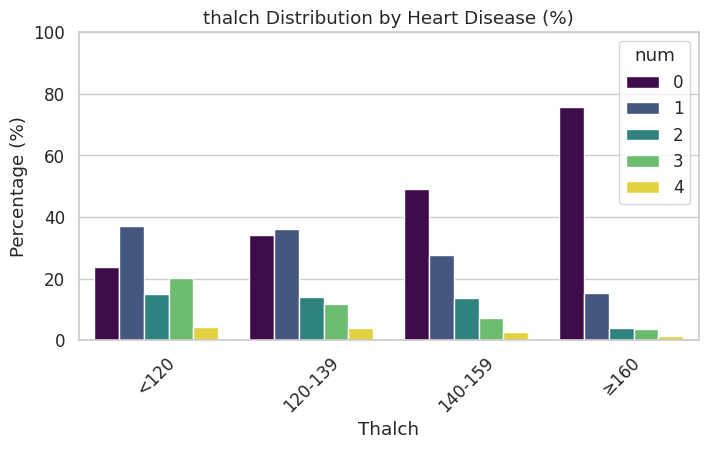

/tmp/ipykernel_55931/502267820.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


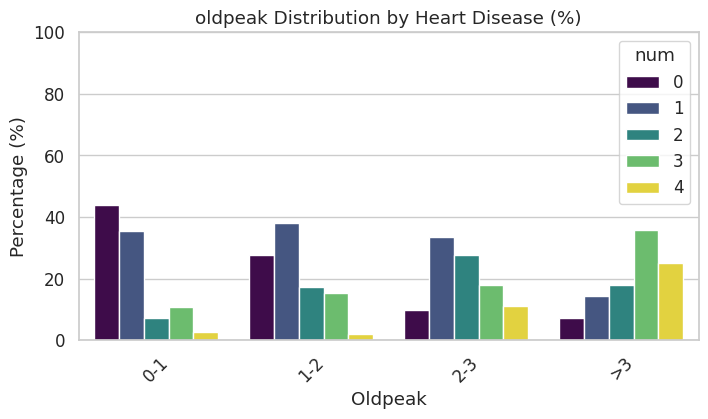

In [6]:
bins_dict = {
    "age": [0, 30, 50, 75, 100],
    "chol": [0, 200, 239, 1000],
    "trestbps": [0, 120, 129, 139, 200],
    "thalch": [0, 120, 139, 159, 220],
    "oldpeak": [0, 1, 2, 3, 10]
}

labels_dict = {
    "age": ["0-30", "31-50", "51-75", "76+"],
    "chol": ["<200", "200-239", "≥240"],
    "trestbps": ["<120","120-129","130-139","≥140"],
    "thalch": ["<120","120-139","140-159","≥160"],
    "oldpeak": ["0-1","1-2","2-3",">3"]
}

for col in bins_dict.keys():
    # Use only non-null values for binning
    temp_series = df[col].dropna()
    df[f"{col}_bin"] = pd.cut(temp_series, bins=bins_dict[col], labels=labels_dict[col])
    
    # Merge back with original index to keep NaNs in place
    df[f"{col}_bin"] = df[f"{col}_bin"].reindex(df.index)
    
    # Compute percentages
    cat_percentages = (
        df.groupby(f"{col}_bin")['num']
        .value_counts(normalize=True)
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    plt.figure(figsize=(8,4))
    sns.barplot(
        data=cat_percentages,
        x=f"{col}_bin", y="percentage",
        hue="num",
        palette=sns.color_palette("viridis", as_cmap=True),
        order=labels_dict[col]
    )
    plt.title(f"{col} Distribution by Heart Disease (%)")
    plt.ylabel("Percentage (%)")
    plt.xlabel(col.capitalize())
    plt.ylim(0,100)
    plt.xticks(rotation=45)
    plt.savefig(f"outputs/figures/{col}_binned_distribution.png", bbox_inches="tight")
    plt.show()

## Step 6. Categorical Features Overview
**Purpose:** Explore categorical variables and their distributions.  
**Approach:** Frequency tables, barplots, and check category counts.  
**Expected Outcome:** Understand categorical composition and potential imbalances.

In [7]:
categorical_vars = df.select_dtypes(include='object').columns.tolist()
for col in categorical_vars:
    print(f"--- {col} ---")
    print(f"Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(5))
    print("\n")

--- sex ---
Unique values: 2
sex
Male      726
Female    194
Name: count, dtype: int64


--- dataset ---
Unique values: 4
dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64


--- cp ---
Unique values: 4
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64


--- trestbps ---
Unique values: 60
trestbps
120.0    131
130.0    115
140.0    102
110.0     59
150.0     56
Name: count, dtype: int64


--- chol ---
Unique values: 216
chol
254.0    10
220.0    10
219.0     9
211.0     9
230.0     9
Name: count, dtype: int64


--- fbs ---
Unique values: 2
fbs
False    692
True     138
Name: count, dtype: int64


--- restecg ---
Unique values: 3
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64


--- exang ---
Unique values: 2
exang
False    528
True     337
Name: count, dtype: int64


--- slope ---
Unique value

## Step 6.1 — Gender vs Target
**Purpose:** Examine whether heart disease prevalence differs by gender.  
**Approach:** Barplots of target percentages per gender.  
**Expected Outcome:** Quantitative insight into gender differences.

Heart Disease Percentage by Gender:


,sex,num,percentage
0,Female,0,74.226804
1,Female,1,15.463918
2,Female,2,5.154639
3,Female,3,4.123711
4,Female,4,1.030928
5,Male,0,36.776860
6,Male,1,32.369146
7,Male,2,13.636364
8,Male,3,13.636364
9,Male,4,3.581267


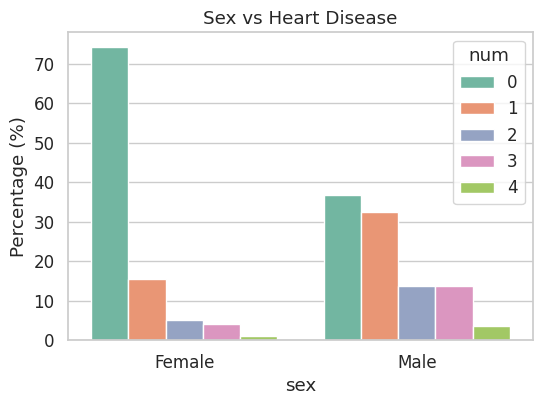

In [8]:
if 'sex' in df.columns:
    sex_disease_percentage = (
        df.groupby('sex')['num']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )
    print("Heart Disease Percentage by Gender:")
    display(sex_disease_percentage)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x='sex', y='percentage', hue='num', data=sex_disease_percentage, palette='Set2')
    plt.title("Sex vs Heart Disease")
    plt.ylabel("Percentage (%)")
    plt.savefig("outputs/figures/sex_vs_target.png", bbox_inches="tight")
    plt.show()


## Step 6.2 — Categorical Features vs Target
**Purpose:** Visualize relationships between each categorical variable and the target.  
**Approach:** Barplots showing percentage distribution of target within each category.  
**Expected Outcome:** Identify categorical features that may be predictive.


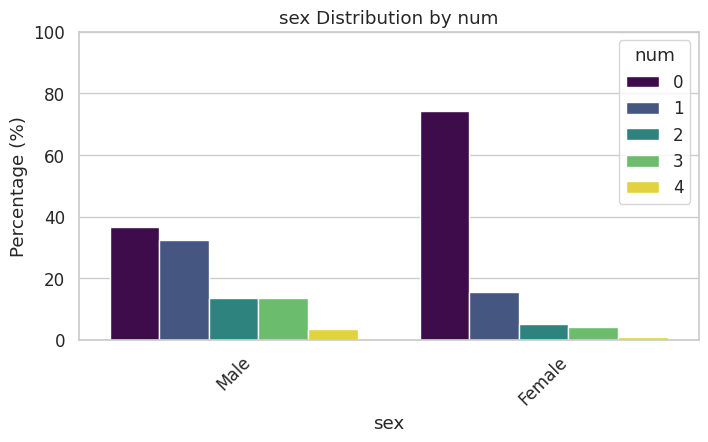

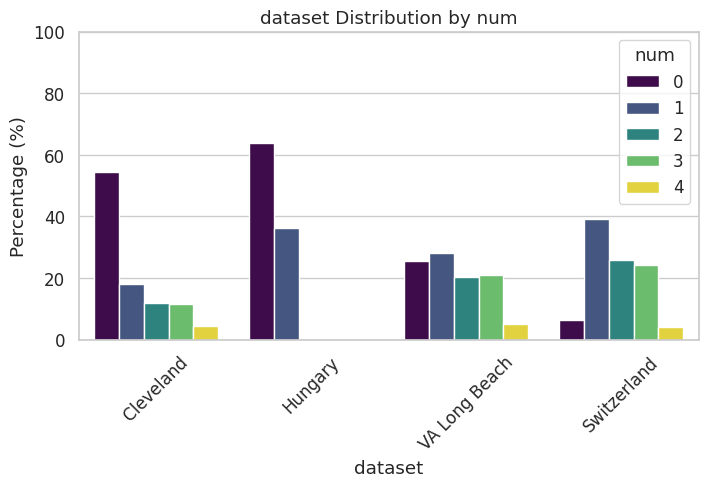

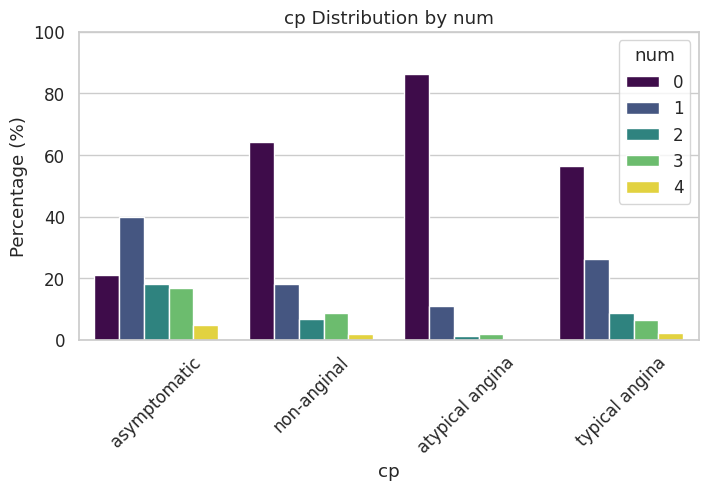

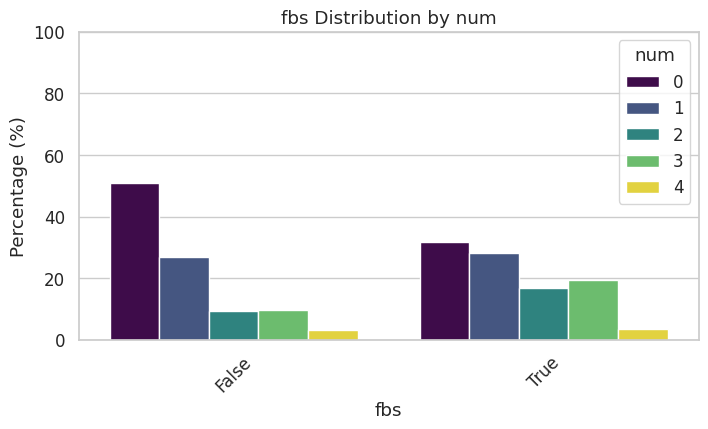

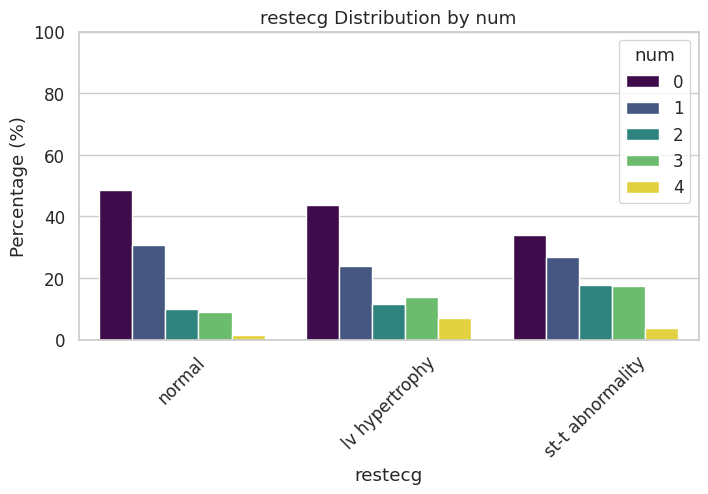

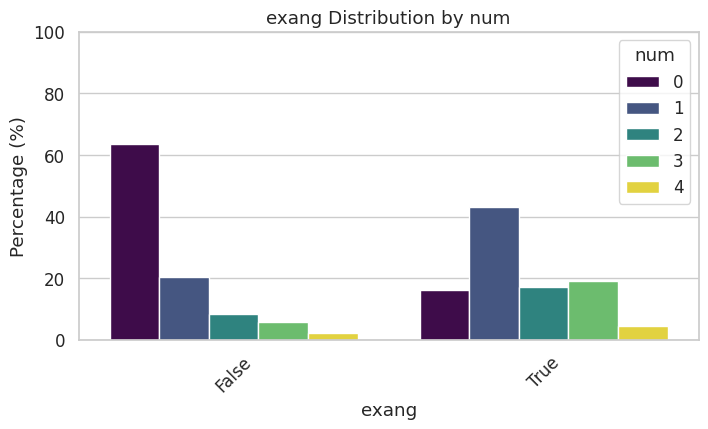

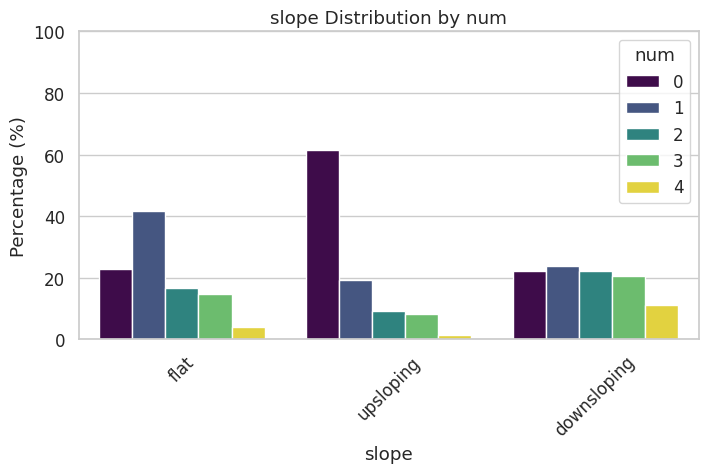

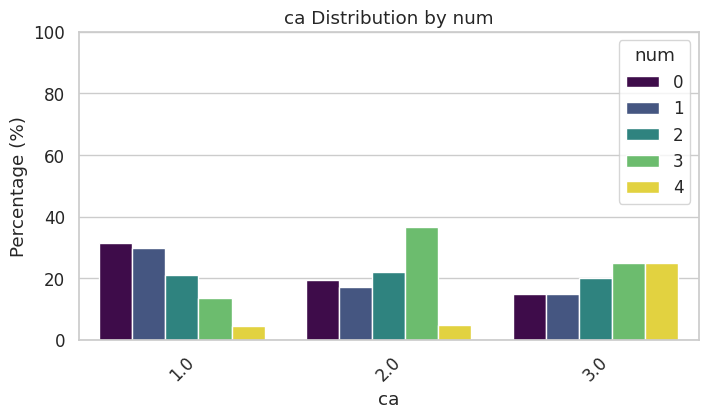

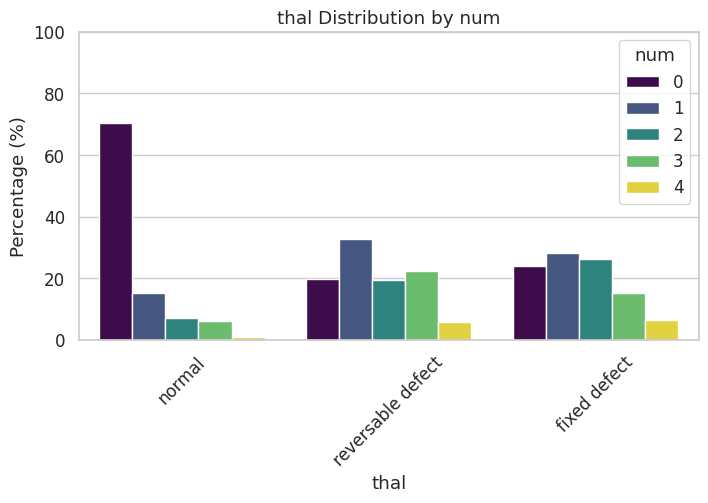

In [9]:
def plot_categorical_percent(df, col, target="num"):
    plt.figure(figsize=(8,4))
    cat_percentages = (
        df.groupby(col)[target]
        .value_counts(normalize=True)
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    sns.barplot(
        data=cat_percentages,
        x=col, y="percentage",
        hue=target,
        palette=sns.color_palette("viridis", as_cmap=True),
        order=df[col].value_counts().index
    )
    plt.xticks(rotation=45)
    plt.ylabel("Percentage (%)")
    plt.title(f"{col} Distribution by {target}")
    plt.ylim(0,100)
    plt.savefig(f"outputs/figures/{col}_categorical_distribution.png", bbox_inches="tight")
    plt.show()

for col in categorical_vars:
    if df[col].nunique() <= 15:
        plot_categorical_percent(df, col)


## Step 7. Categorical Association: Cramér's V
**Purpose:** Quantify association strength between categorical features and target.  
**Approach:** Compute Cramér’s V for each categorical feature.  
**Expected Outcome:** Rank categorical features by predictive potential.

In [10]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

cat_assoc = {}
for col in categorical_vars:
    confusion_mat = pd.crosstab(df[col], df['num'])
    cat_assoc[col] = cramers_v(confusion_mat)

cat_assoc_df = pd.DataFrame.from_dict(cat_assoc, orient='index', columns=['Cramers_V'])
cat_assoc_df = cat_assoc_df.sort_values(by='Cramers_V', ascending=False)
display(cat_assoc_df)
cat_assoc_df.to_csv("outputs/datasets/collection/categorical_cramersV.csv")


,Cramers_V
exang,0.463451
thal,0.350370
cp,0.307443
sex,0.301836
dataset,0.298420
slope,0.280915
ca,0.217060
trestbps,0.162595
fbs,0.157898
restecg,0.130610


## Step 8. Numeric Correlation Analysis
**Purpose:** Identify strongest numeric predictors.  
**Approach:** Compute Spearman and Pearson correlations with target.  
**Expected Outcome:** Ranked numeric features for candidate selection.


In [11]:
numeric_cols = df.select_dtypes(include='number')
corr_spearman = numeric_cols.corr(method='spearman')['num'].sort_values(key=abs, ascending=False)[1:]
corr_pearson = numeric_cols.corr(method='pearson')['num'].sort_values(key=abs, ascending=False)[1:]

print("Top Spearman correlations:")
display(corr_spearman.head(10))

print("Top Pearson correlations:")
display(corr_pearson.head(10))


Top Spearman correlations:


oldpeak    0.434273
thalch    -0.398360
age        0.347184
id         0.325659
Name: num, dtype: float64

Top Pearson correlations:


oldpeak    0.443084
thalch    -0.366265
age        0.339596
id         0.273552
Name: num, dtype: float64

## Step 9. Candidate Feature Selection
**Purpose:** Create shortlist of features for modeling.  
**Approach:** Combine top numeric (Spearman + Pearson) and top categorical (Cramér’s V) features.  
**Expected Outcome:** Final candidate feature list for Notebook 3.


In [12]:
num_top = list(set(corr_spearman.head(5).index.to_list() + corr_pearson.head(5).index.to_list()))
cat_top = cat_assoc_df.head(5).index.to_list()

top_features = list(set(num_top + cat_top))
print("Candidate features for modeling:")
print(top_features)


Candidate features for modeling:
['id', 'thalch', 'sex', 'cp', 'exang', 'oldpeak', 'dataset', 'thal', 'age']


## Step 10. Correlation Heatmaps & Pairplots
**Purpose:** Visualize feature interactions and relationships with target.  
**Approach:** Heatmaps (overall + top 3 Spearman) and pairplots including gender hue.  
**Expected Outcome:** Confirm feature relationships, redundancy, and patterns.


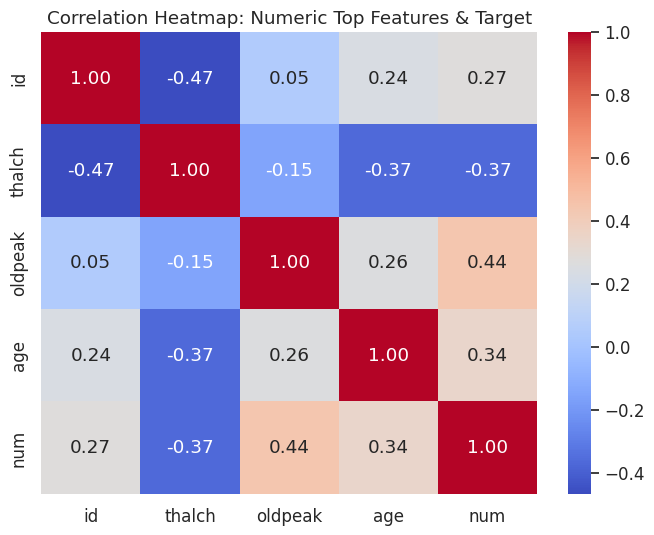

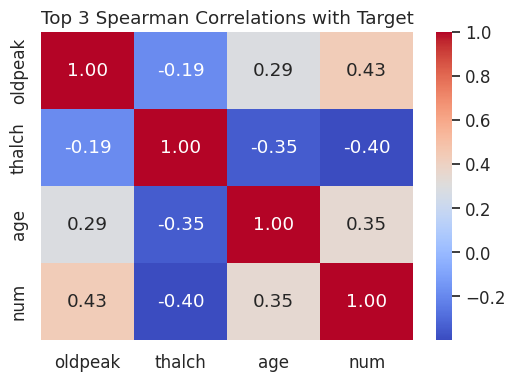

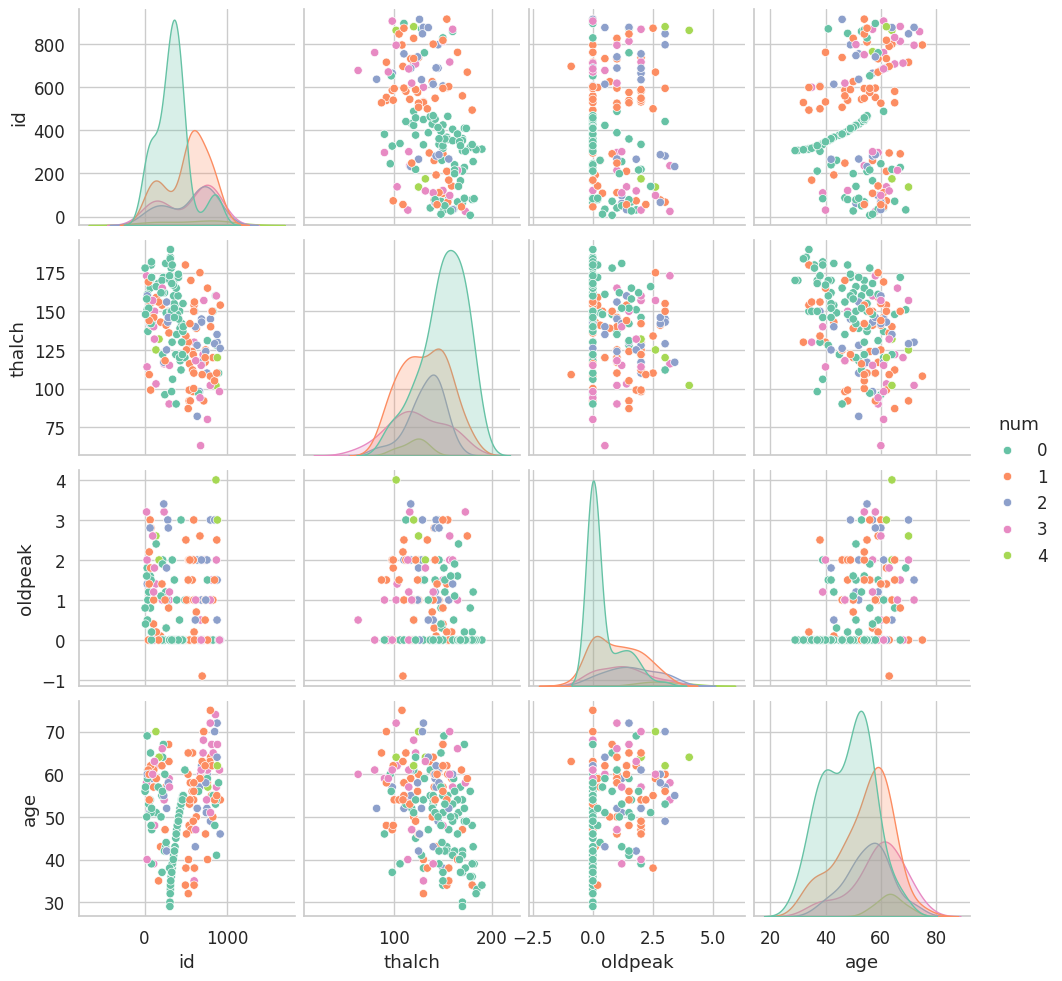

In [13]:
# Select numeric top features
numeric_top_features = [col for col in top_features if pd.api.types.is_numeric_dtype(df[col])]
df_corr = df[numeric_top_features + ['num']].copy()

# Overall heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Numeric Top Features & Target")
plt.savefig("outputs/figures/numeric_top_features_heatmap.png", bbox_inches="tight")
plt.show()

# Top 3 Spearman correlations
top3_features = corr_spearman.head(3).index.tolist()
top3_features = [col for col in top3_features if col in numeric_top_features]  # ensure numeric
df_top3 = df[top3_features + ['num']]

plt.figure(figsize=(6,4))
sns.heatmap(df_top3.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 3 Spearman Correlations with Target")
plt.savefig("outputs/figures/top3_spearman_heatmap.png", bbox_inches="tight")
plt.show()

# Pairplot (downsample 200 rows)
sns.pairplot(df_corr.sample(200, random_state=42), vars=numeric_top_features, hue='num', diag_kind='kde', palette='Set2')
plt.savefig("outputs/figures/pairplot_numeric.png", bbox_inches="tight")
plt.show()



## Step 11. Gender-Based Boxplots
**Purpose:** Visualize key feature distributions by gender.  
**Approach:** Boxplots for age, thalach, oldpeak.  
**Expected Outcome:** Detect gender-related differences in numeric features.


/tmp/ipykernel_55931/1287914086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y=feature, data=df, palette='Set2', ax=axes[i])
/tmp/ipykernel_55931/1287914086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y=feature, data=df, palette='Set2', ax=axes[i])
/tmp/ipykernel_55931/1287914086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y=feature, data=df, palette='Set2', ax=axes[i])


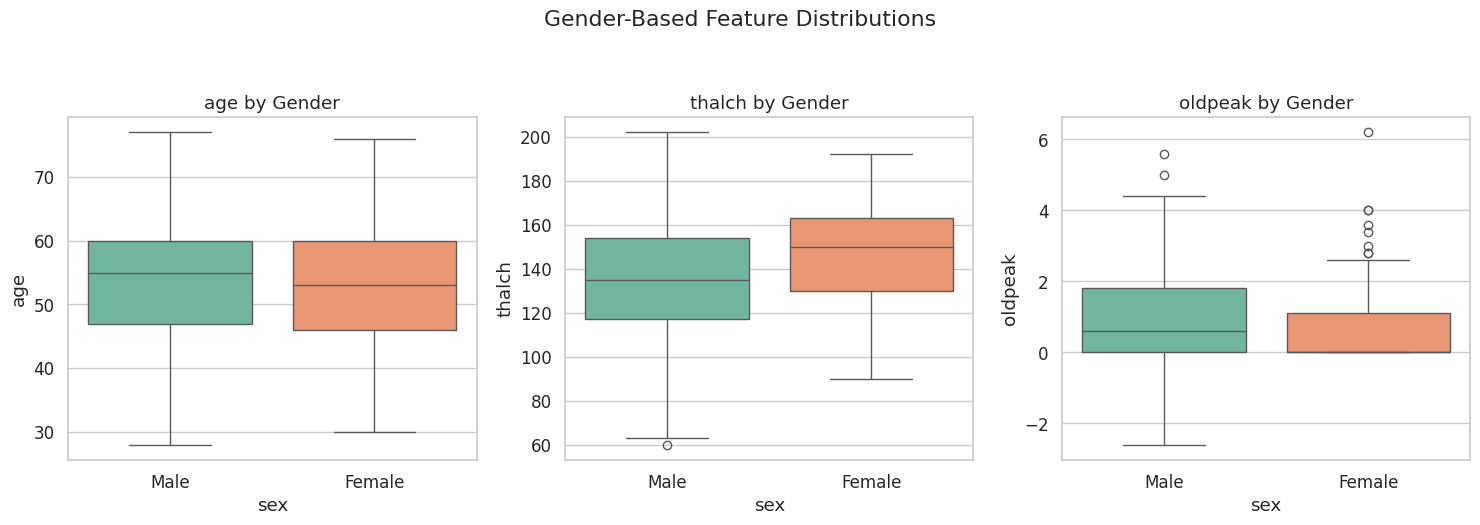

In [14]:
gender_features = ['age', 'thalch', 'oldpeak']
if 'sex' in df.columns:
    fig, axes = plt.subplots(1, len(gender_features), figsize=(15,5))
    for i, feature in enumerate(gender_features):
        sns.boxplot(x='sex', y=feature, data=df, palette='Set2', ax=axes[i])
        axes[i].set_title(f"{feature} by Gender")
    plt.suptitle("Gender-Based Feature Distributions", y=1.05)
    plt.tight_layout()
    plt.savefig("outputs/figures/gender_boxplots.png", bbox_inches="tight")
    plt.show()


## Step 12. Spearman Correlation by Target Class
**Purpose:** Examine feature relationships within each target class.  
**Approach:** Compute heatmaps of Spearman correlations per class.  
**Expected Outcome:** Detect class-specific patterns and correlations.


/tmp/ipykernel_55931/1100396990.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spearman_corr_target.values, y=spearman_corr_target.index, palette='viridis')


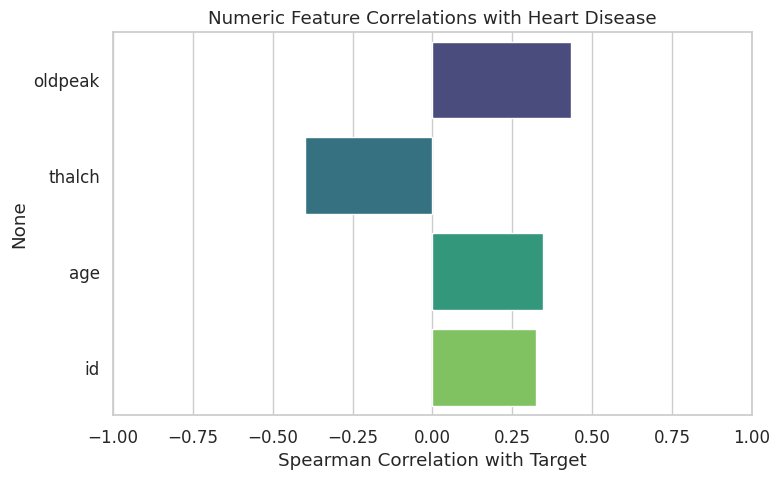

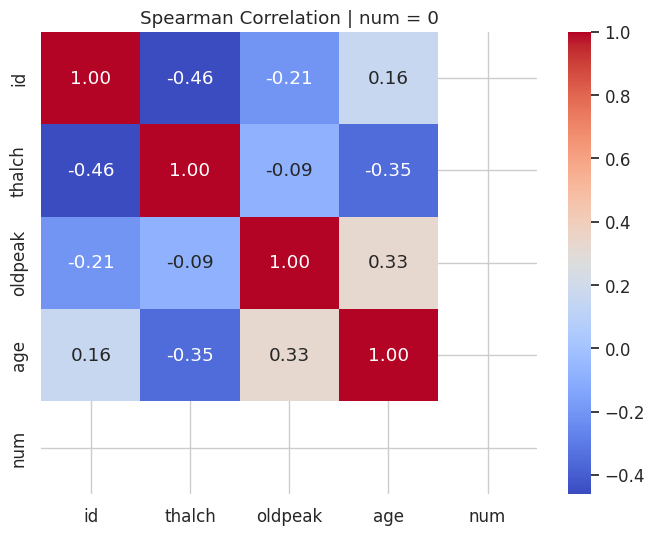

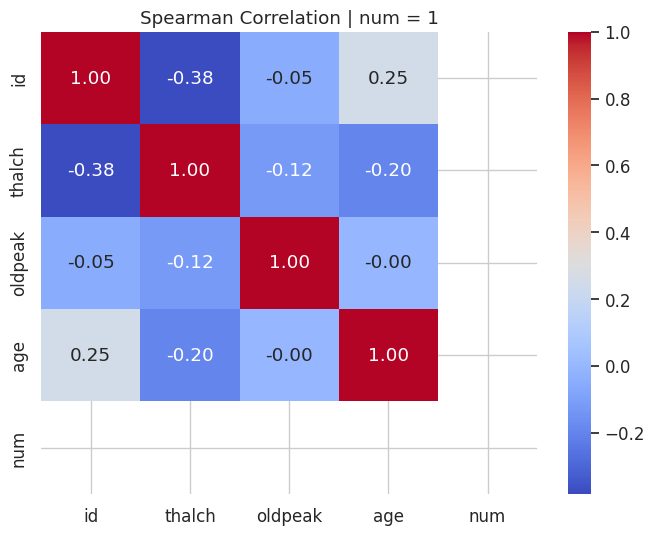

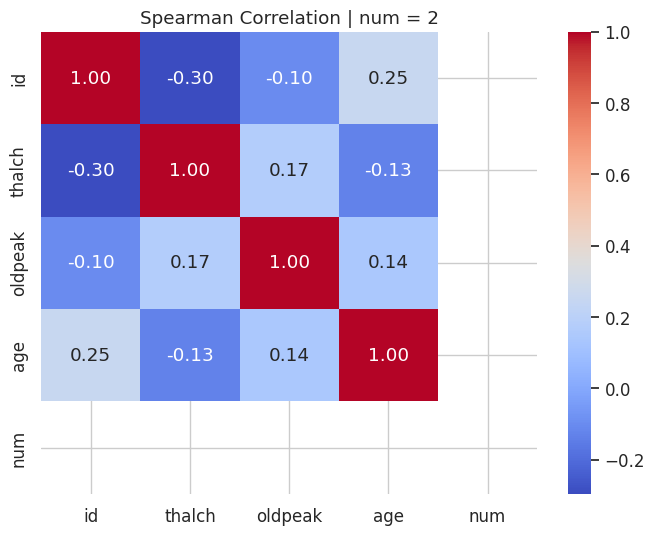

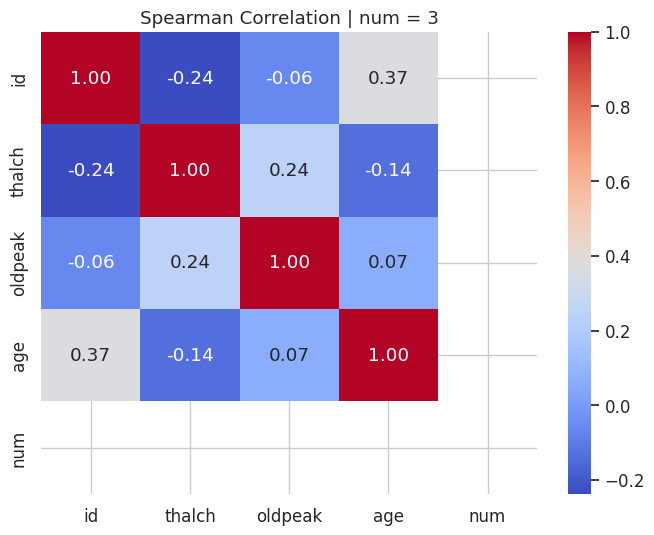

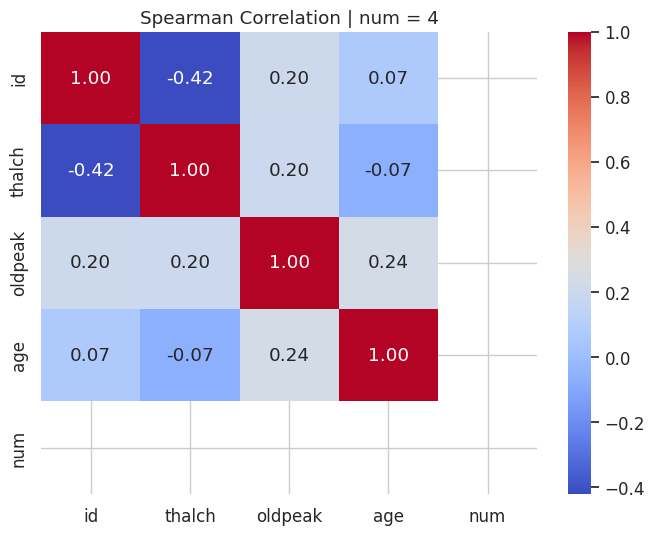

In [15]:
## Keep only numeric top features + target
numeric_top_features = [col for col in top_features if pd.api.types.is_numeric_dtype(df[col])]
df_corr = df[numeric_top_features + ['num']].copy()


# Compute Spearman correlation with target
spearman_corr_target = df[numeric_top_features + ['num']].corr(method='spearman')['num'].drop('num')
spearman_corr_target = spearman_corr_target.sort_values(key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=spearman_corr_target.values, y=spearman_corr_target.index, palette='viridis')
plt.xlabel("Spearman Correlation with Target")
plt.title("Numeric Feature Correlations with Heart Disease")
plt.xlim(-1,1)
plt.tight_layout()
plt.savefig("outputs/figures/numeric_corr_target.png", bbox_inches="tight")
plt.show()

# By target class
for label in sorted(df_corr['num'].dropna().unique()):
    subset = df_corr[df_corr['num'] == label]
    plt.figure(figsize=(8,6))
    sns.heatmap(subset.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Spearman Correlation | num = {label}")
    plt.savefig(f"outputs/figures/spearman_class_{label}.png", bbox_inches="tight")
    plt.show()

## Step 13. Save Cleaned Dataset
**Purpose:** Prepare dataset for downstream modeling.  
**Approach:** Replace impossible zeros with NA, save inspected dataset.  
**Expected Outcome:** Ready-to-use dataset for Notebook 3.


In [16]:
# Already replaced trestbps, chol, ca zeros with NA in earlier steps
df.to_csv("outputs/datasets/collection/heart_disease_inspected.csv", index=False)
print("Cleaned dataset saved at outputs/datasets/collection/heart_disease_inspected.csv")


Cleaned dataset saved at outputs/datasets/collection/heart_disease_inspected.csv


## Step 14. Optional: Automated Profiling Report
**Purpose:** Quickly generate an overall dataset summary.  
**Approach:** Use `ydata_profiling` to create HTML report.  
**Expected Outcome:** High-level EDA including correlations, missing values, and distributions.


In [17]:
if PROFILING_AVAILABLE:
    profile = ProfileReport(df, title="Heart Disease Dataset Profiling", minimal=True)
    profile.to_file("outputs/figures/eda_profile.html")
    print("Automated profiling report saved at outputs/figures/eda_profile.html")
else:
    print("ydata_profiling not installed; skipping automated profiling.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Automated profiling report saved at outputs/figures/eda_profile.html


# ✅ Conclusion — EDA & Feature Selection

**Summary of Work Completed:**
1. Verified dataset integrity and inspected missing values.
2. Analyzed target variable distribution; identified class imbalance.
3. Explored numeric features with histograms and binned distributions.
4. Explored categorical variables; calculated Cramér’s V for predictive ranking.
5. Computed Spearman and Pearson correlations; identified top numeric features.
6. Compiled candidate feature list (numeric + categorical) for modeling.
7. Visualized feature interactions (pairplots, heatmaps, top 3 correlations).
8. Gender-based feature differences highlighted with boxplots.
9. Saved cleaned dataset and generated figures for reporting.
10. Optional automated profiling report produced for high-level insight.

**Next Steps (Notebook 3 — Data Cleaning & Preprocessing):**
- Handle missing values and outliers.
- Encode categorical variables.
- Scale/normalize numeric features as appropriate.
- Finalize modeling feature set based on EDA insights.


---